In [2]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
import matplotlib.pyplot as plt
import pandas as pd
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split # if needed 
import cv2 #  for camera access
from scipy import ndimage

In [3]:
CSV_FILE_TEST = 'mnist_test.csv'
CSV_FILE_TRAIN = 'mnist_train.csv'

In [4]:
try:
    test_df = pd.read_csv(CSV_FILE_TEST)
    train_df = pd.read_csv(CSV_FILE_TRAIN)
except FileNotFoundError:
    print(f"Error: '{CSV_FILE_TEST}' not found.")
    print("need to download a MNIST CSV file and place it in the same directory as this script...")
    exit()


In [5]:
#2 process the training data
train_labels = train_df['label'].values
train_images = train_df.drop('label', axis=1).values
# normalize and reshape the training images
train_images = train_images.astype('float32') / 255.0
train_images = train_images.reshape(-1, 28, 28, 1)

In [6]:
#3 Process the testing data
test_labels = test_df['label'].values
test_images = test_df.drop('label', axis=1).values
# Normalize and reshape the testing images
test_images = test_images.astype('float32') / 255.0
test_images = test_images.reshape(-1, 28, 28, 1)

In [7]:

#4  define model architecture 
model = Sequential([
    # First convolutional layer with 32 filters and a 3x3 kernel
    Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    # Max pooling layer to reduce the spatial dimensions
    MaxPooling2D((2, 2)),
    # Second convolutional layer with 64 filters, use dropout to not make model too biased!
    Dropout(.25),
    Conv2D(64, (3, 3), activation='relu'),
    # Another max pooling layer
    MaxPooling2D((2, 2)),
    # Flatten the output to feed into a dense layer
    Dropout(.25),
    Flatten(),
    # Dense layer with 128 neurons
    Dense(128, activation='relu'),
    # Output layer with 10 neurons (one for each class) and softmax activation
    Dropout(0.5),
    Dense(10, activation='softmax')
])


/Users/leonardofloresgonzalez/CNN MNSIT Project/env/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [8]:
#5 compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [9]:
#6 train the model
history = model.fit(train_images, train_labels, epochs=2, validation_data=(test_images, test_labels))

Epoch 1/2
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - accuracy: 0.9194 - loss: 0.2589 - val_accuracy: 0.9842 - val_loss: 0.0501
Epoch 2/2
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - accuracy: 0.9702 - loss: 0.1011 - val_accuracy: 0.9889 - val_loss: 0.0357


In [10]:
#7 accuracy results of tests
test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)
print(f'\nTest accuracy: {test_acc:.4}')

313/313 - 1s - 2ms/step - accuracy: 0.9889 - loss: 0.0357

Test accuracy: 0.9889


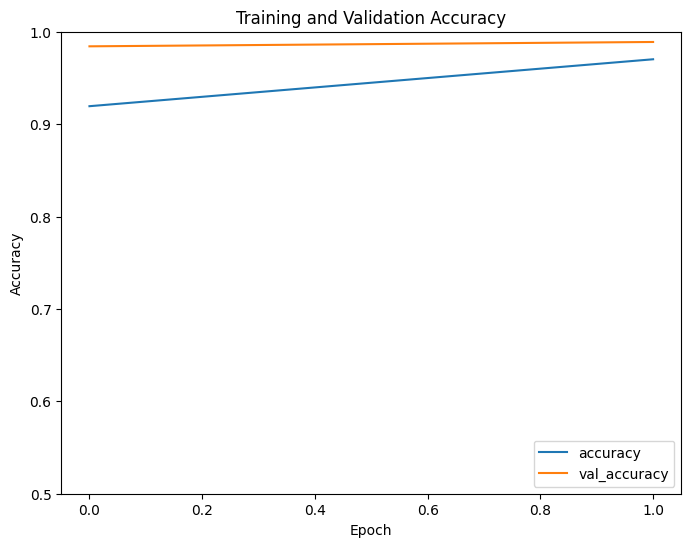

In [11]:

#8  plot training and validation accuracy
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.show()

In [13]:
#9 Live Digit Recognition with Camera
print("\nStarting live digit recognition...")
print("Hold a white paper with a black number in the green box.")
print("Press 'q' to quit.")

# Starts video capture
cap = cv2.VideoCapture(0)

# define and make the Region of Interest (ROI) box
roi_x, roi_y, roi_w, roi_h = 400, 300, 250, 250

while True:
    # read a frame from the camera
    ret, frame = cap.read()
    if not ret:
        break

    # Flip the frame horizontally for a more natural mirror-like view
    #frame = cv2.flip(frame, 1)
    # DO NOT FLIP!!! MODEL WILL READ REVERSED NUMBERS LEADING TO INCORRECT PREDICTIONS!!!

    # this draws the ROI box on the frame
    cv2.rectangle(frame, (roi_x, roi_y), (roi_x + roi_w, roi_y + roi_h), (0, 255, 0), 2)

    # Extract the ROI
    roi = frame[roi_y:roi_y + roi_h, roi_x:roi_x + roi_w]

    # Preprocess the ROI for the model
    # Convert to grayscale
    gray = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
    # Apply thresholding to get a binary image (black digit on white background)
    # We use adaptive thresholding for better results in varying lighting
    binary = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                   cv2.THRESH_BINARY_INV, 11, 2)

    # Find contours to locate the digit
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    prediction_text = "Prediction: None"
    
    if contours:
        # Get the largest contour
        largest_contour = max(contours, key=cv2.contourArea)
        
        # Get the bounding box of the digit
        x, y, w, h = cv2.boundingRect(largest_contour)
        
        # Extract the digit
        digit = binary[y:y+h, x:x+w]

        if digit.size > 0:
            # add padding to make it square for model
            side = max(w, h)
            padded_digit = np.zeros((side, side), dtype=np.uint8)
            x_offset = (side - w) // 2
            y_offset = (side - h) // 2
            padded_digit[y_offset:y_offset+h, x_offset:x_offset+w] = digit
            
            # resize to 28x28 for the model
            resized_digit = cv2.resize(padded_digit, (28, 28))
            
            # prepare the image for the model
            processed_digit = resized_digit.astype('float32') / 255.0
            model_input = processed_digit.reshape(1, 28, 28, 1)
            
            # make a prediction
            prediction = model.predict(model_input)
            predicted_digit = np.argmax(prediction)
            
            prediction_text = f"Prediction: {predicted_digit}"

    # displays prediction on frame
    cv2.putText(frame, prediction_text, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)

    # show the frame
    cv2.imshow('Live Digit Recognition', frame)

    # Break loop if 'q' pressed
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()



Starting live digit recognition...
Hold a white paper with a black number in the green box.
Press 'q' to quit.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━